In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [21]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In [24]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
list('00000')
for binarystring in bitstrings:
    z = np.array(list(binarystring), dtype=int) # is a list of integer representing the current binary string
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


In [25]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    print(Q)
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.3

In [26]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

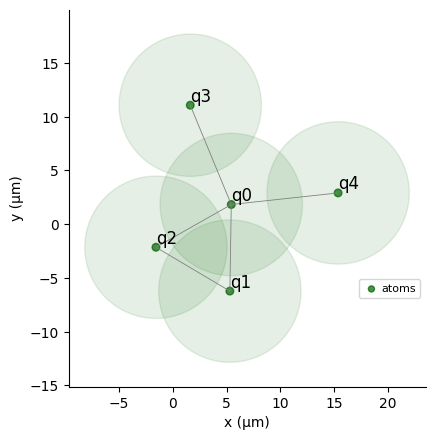

In [ ]:
qubits = {'q0': np.array([5.43591935, 1.83221016]),
 'q1': np.array([ 5.30433156, -6.2289737 ]),
 'q2': np.array([-1.57590666, -2.14702291]),
 'q3': np.array([ 1.61714433, 11.07433973]),
 'q4': np.array([15.37762057,  2.91043984])}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [97]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)


for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [ ]:
import time
def quantum_loop(parameters,disable_save=True):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ch0", "rydberg_global")

    t_list = seq.declare_variable("t_list", size=LAYERS)
    s_list = seq.declare_variable("s_list", size=LAYERS)


    for t, s in zip(t_list, s_list):
        pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
        pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

        seq.add(pulse_1, "ch0")
        seq.add(pulse_2, "ch0")

    seq.measure("ground-rydberg")
    
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    if disable_save == False:
        assigned_seq.draw()
        s_readable = assigned_seq.to_abstract_repr(
        json_dumps_options={"indent": 1},
        seq_name="qaoa_seq",
        )
        with open(f"qaoa2{time.time()}.json", "w") as f:
            f.write(s_readable)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [111]:
LAYERS = 2
np.random.seed(151)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}
# optimal_array = [[9.34167118, 2.27130768],
#  [8.57625465 ,2.70184433],
#  [8.46303954, 2.45161533],
#  [9.11268288 ,2.22450115],
#  [9.31664128, 2.447587  ],
#  [8.85598306, 1.64633822],
#  [9.97253034, 1.72514458],
#  [9.38000773, 1.45700094],
#  [8.97176167, 1.58918132],
#  [8.78742231, 2.26445045],
#  [8.68820589, 1.18535679],
#  [9.46854535, 1.86786162],
#  [9.1088774 , 1.8637817 ],
#  [8.12832316, 1.98956513],
#  [8.80580329, 1.85219168],
#  [9.48645651, 1.62631664],
#  [8.37422211, 1.85474882],
#  [8.36012661, 2.80727353],
#  [9.07311243 ,2.89151002],
#  [9.07366547, 2.0058863 ]]

# [[10.22251347,  2.49894049],
#  [ 9.2351566,   1.7927563 ],
#  [ 7.17415459,  3.10382428],
#  [ 8.54410561,  2.49094206]]
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])
example_dict


UnboundLocalError: cannot access local variable 'assigned_seq' where it is not associated with a value

In [101]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

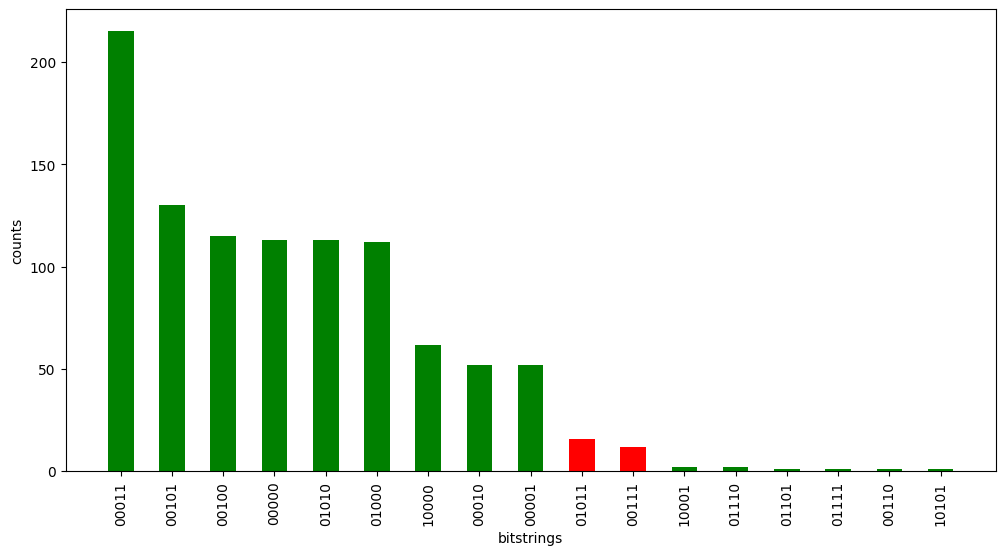

In [102]:
plot_distribution(example_dict)

In [106]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [ ]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

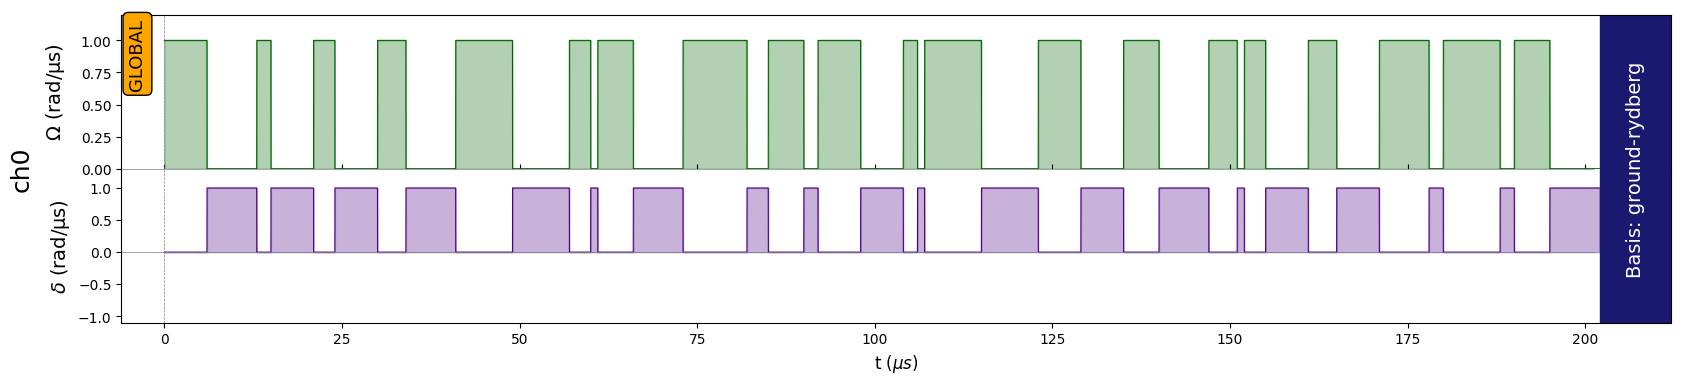

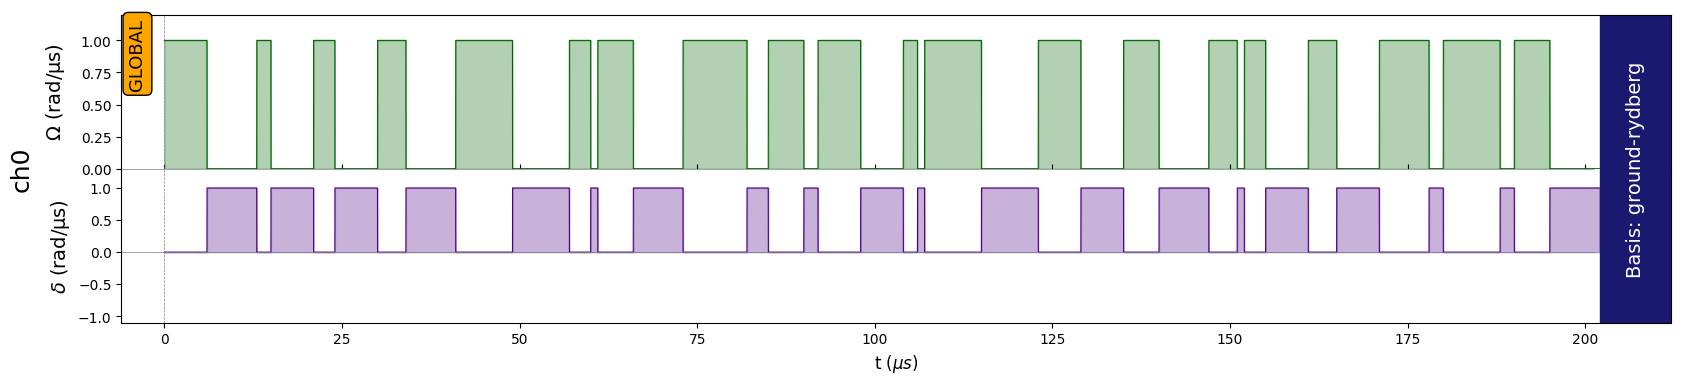

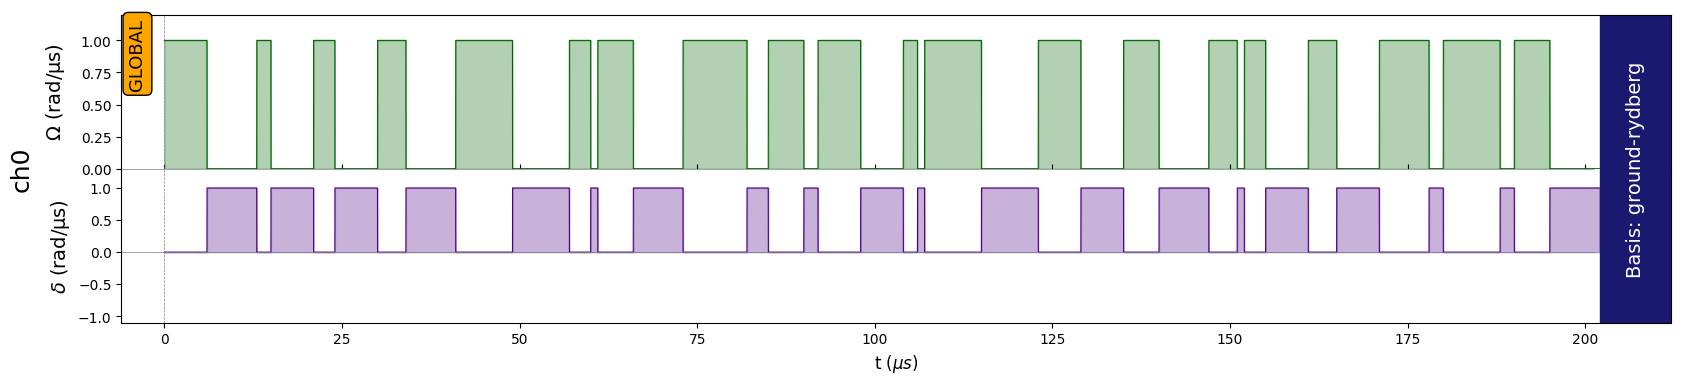

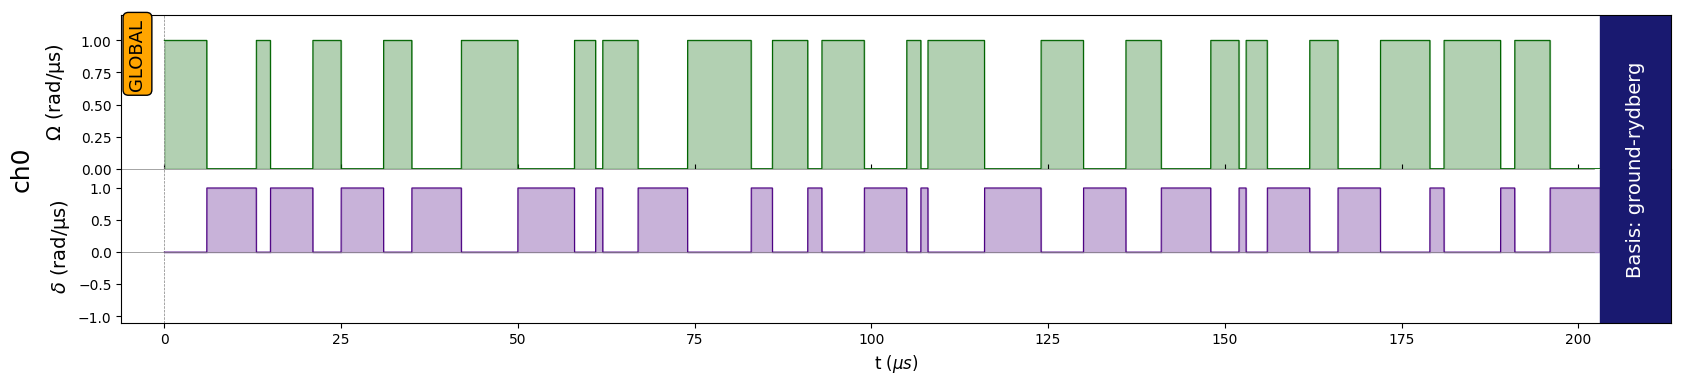

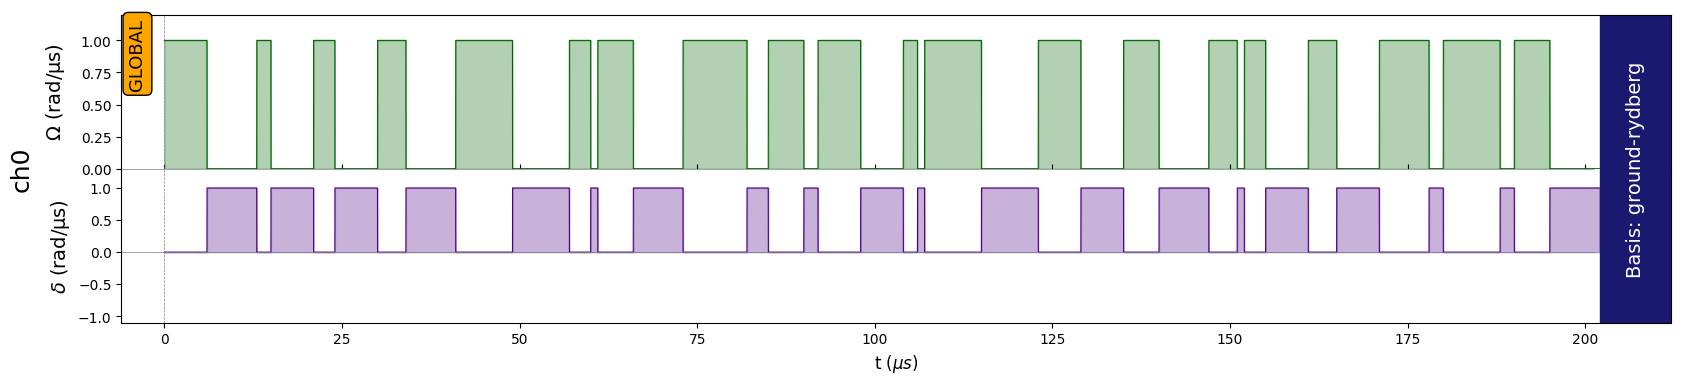

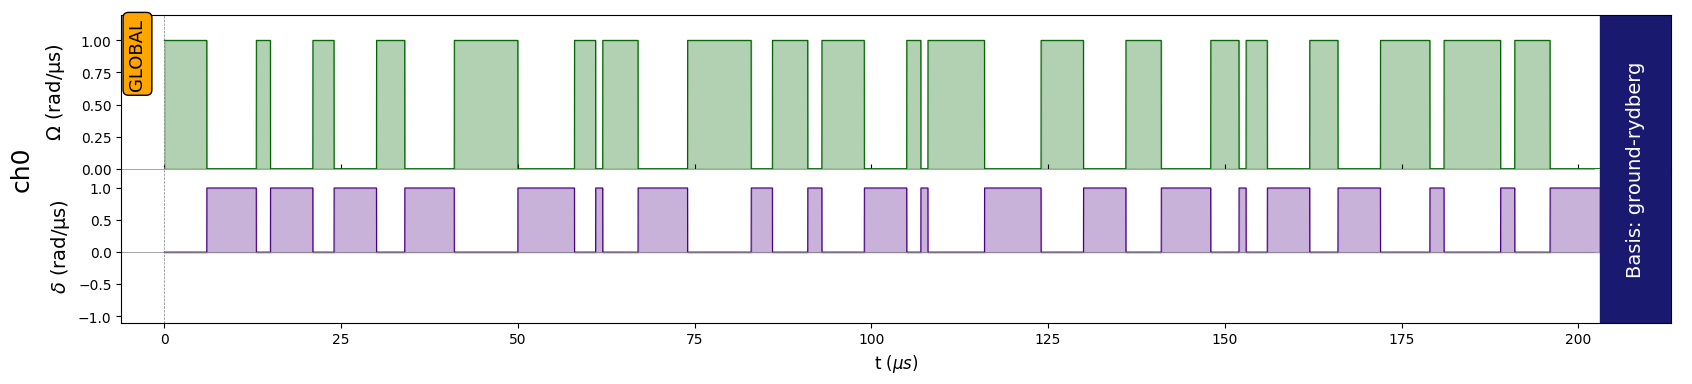

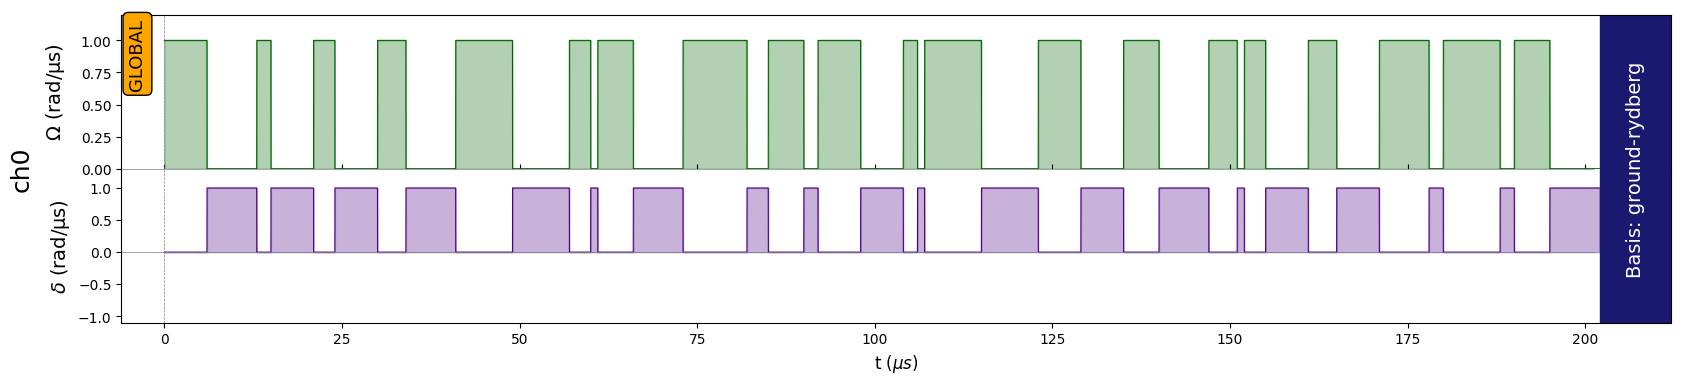

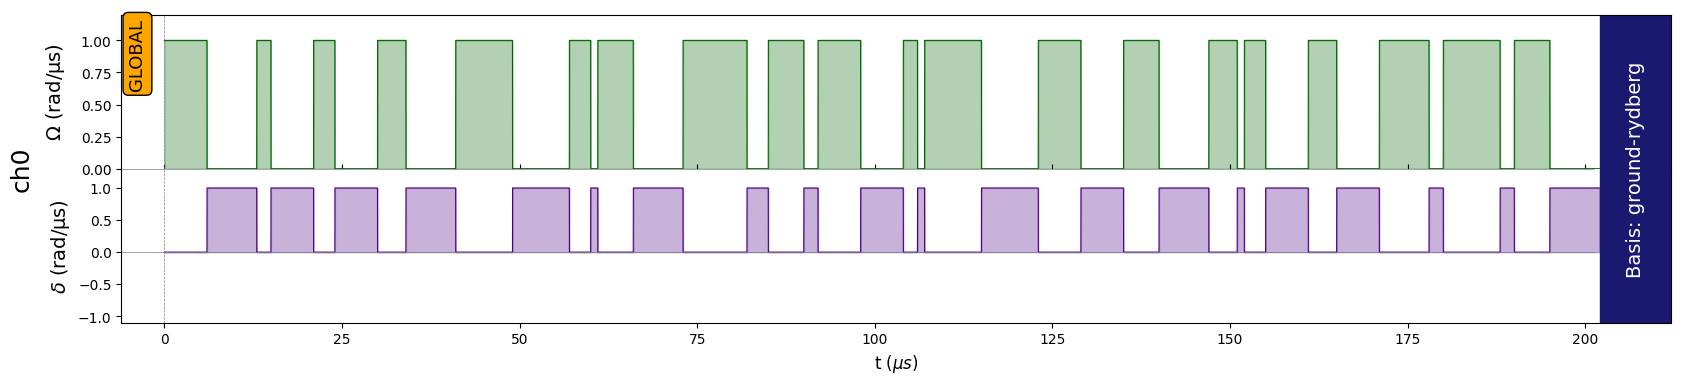

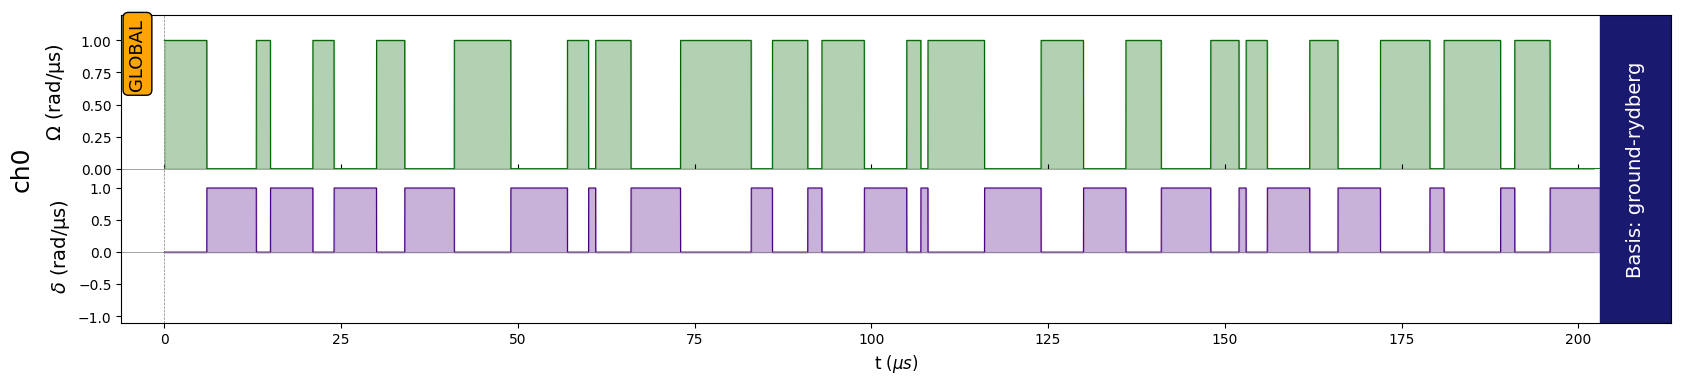

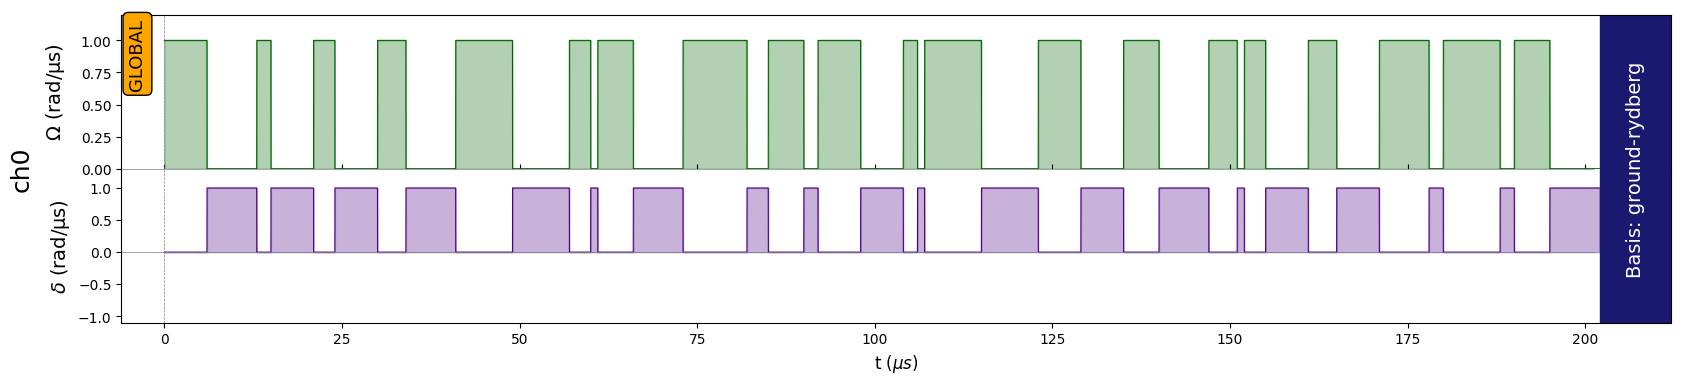

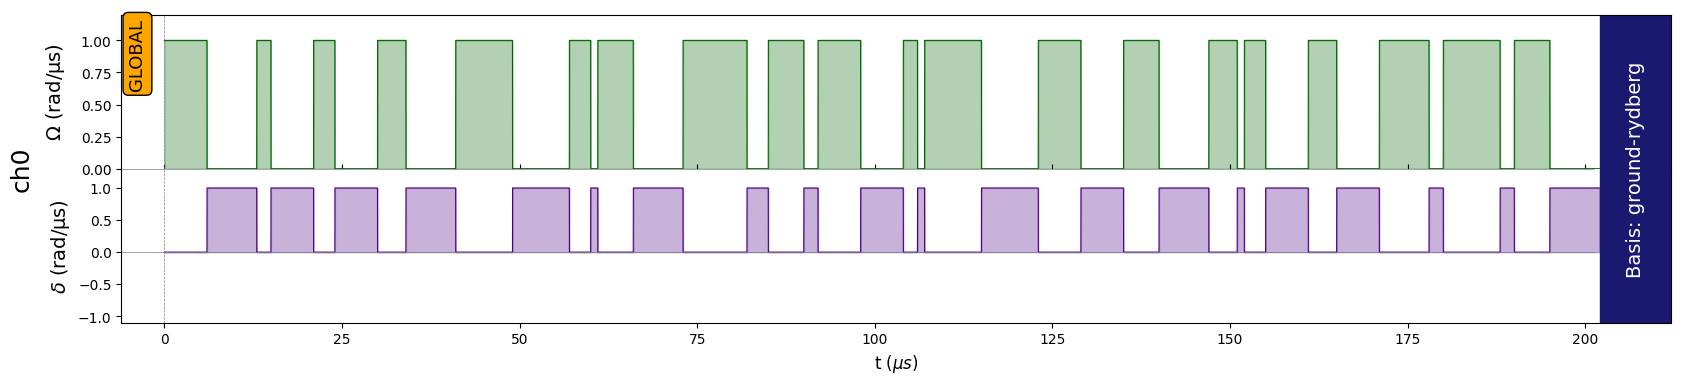

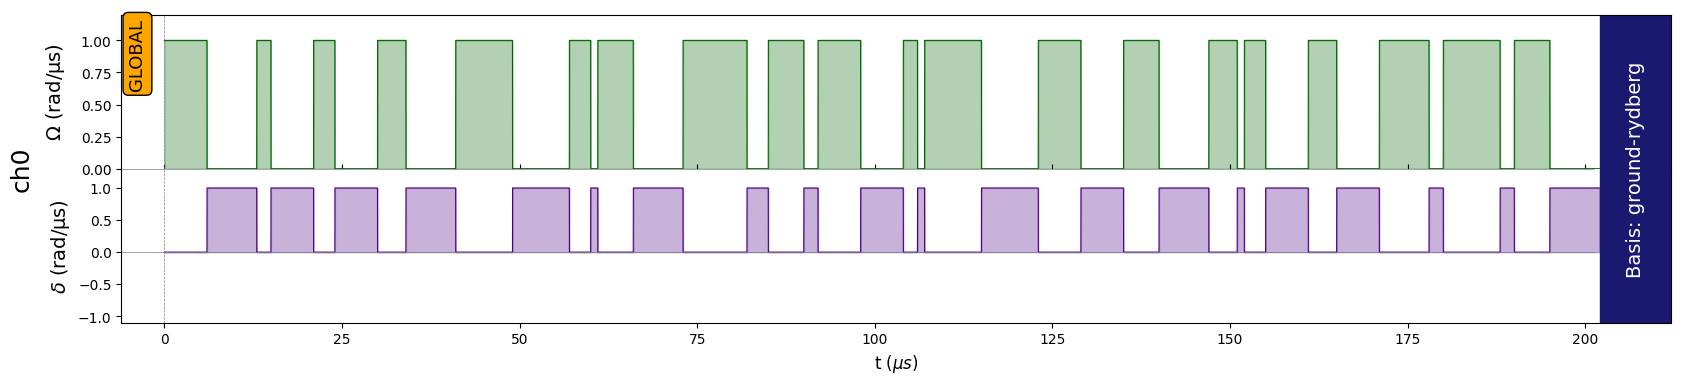

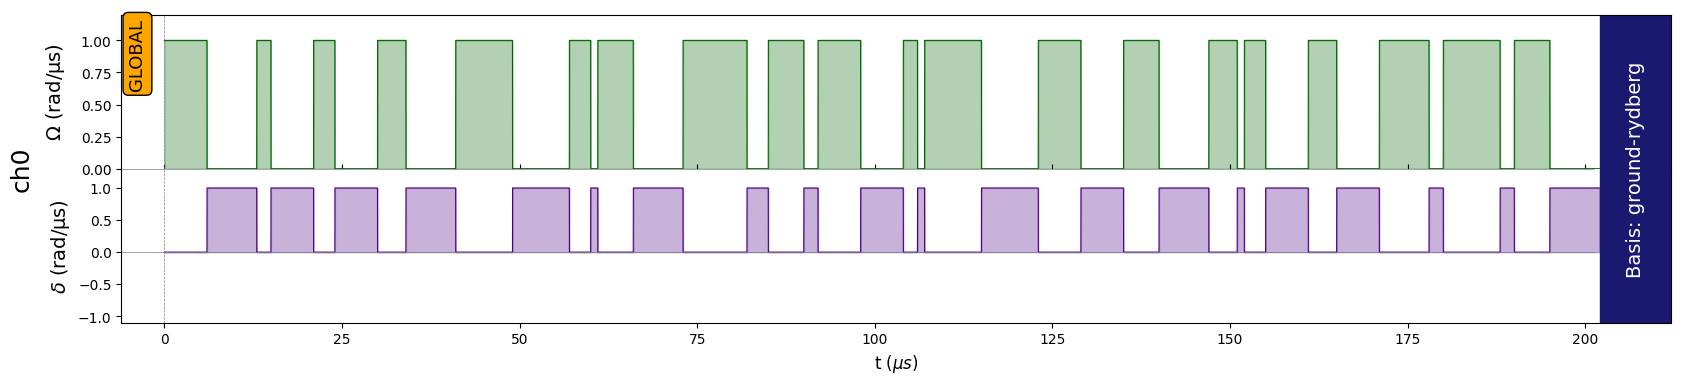

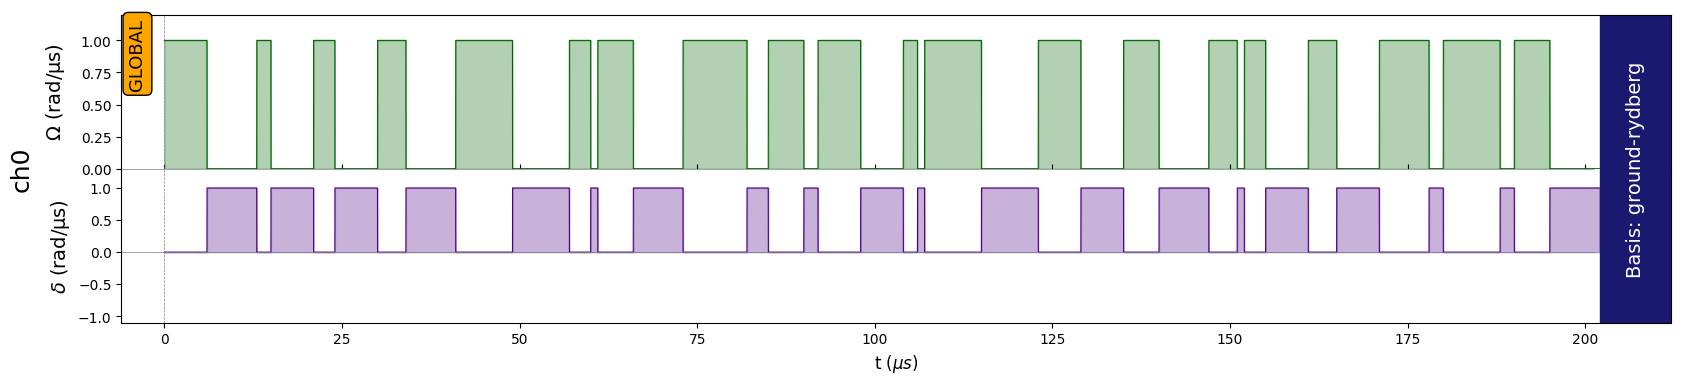

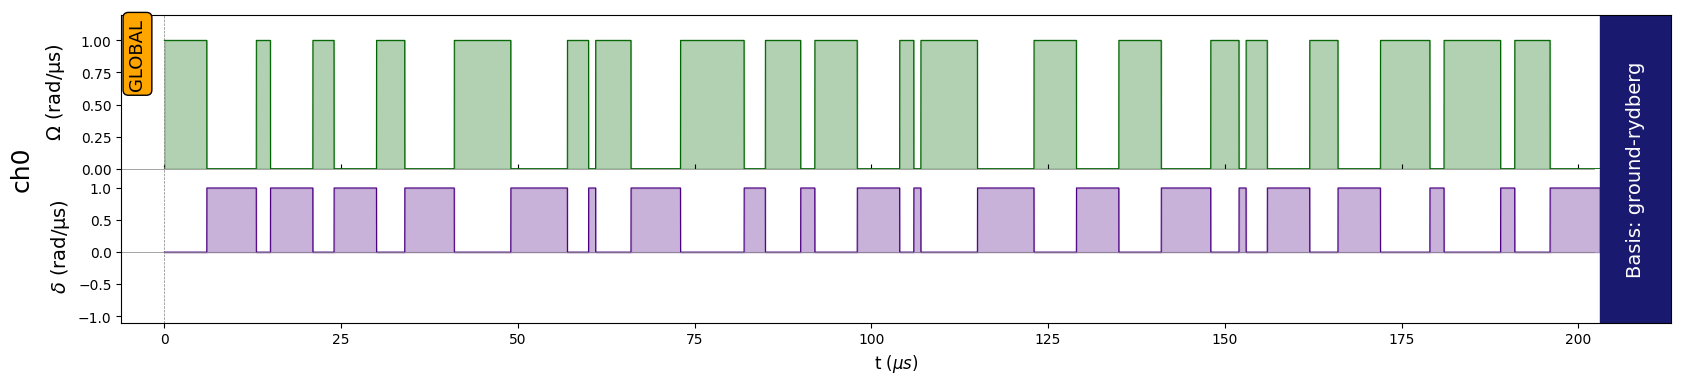

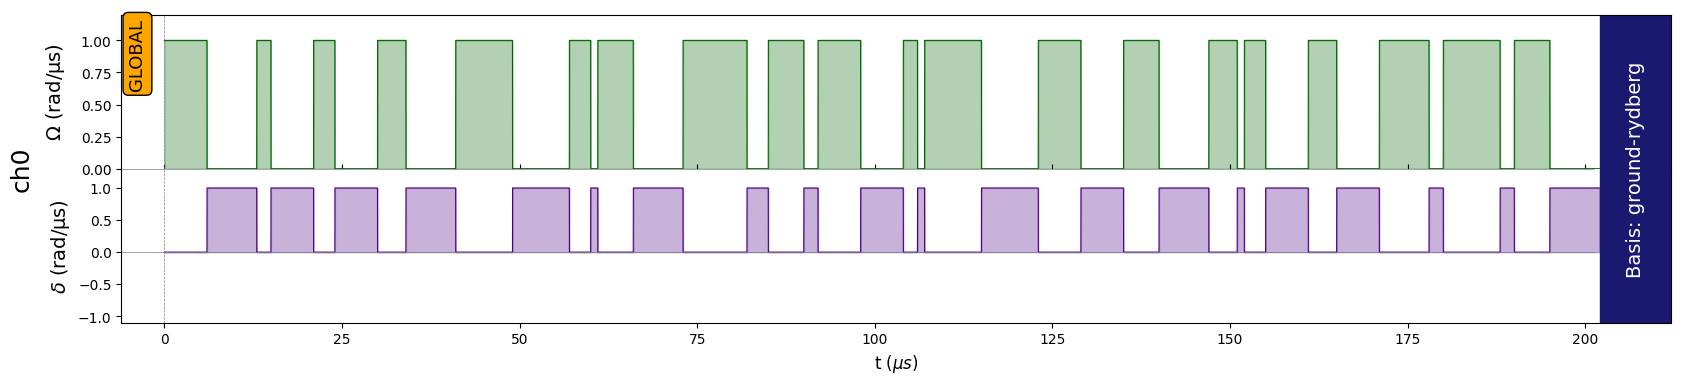

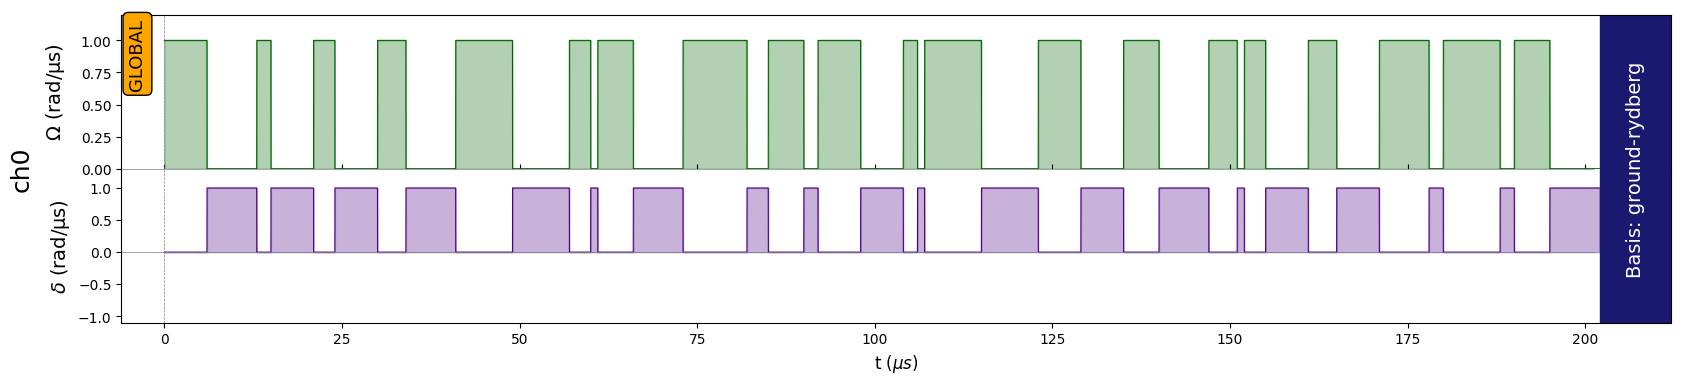

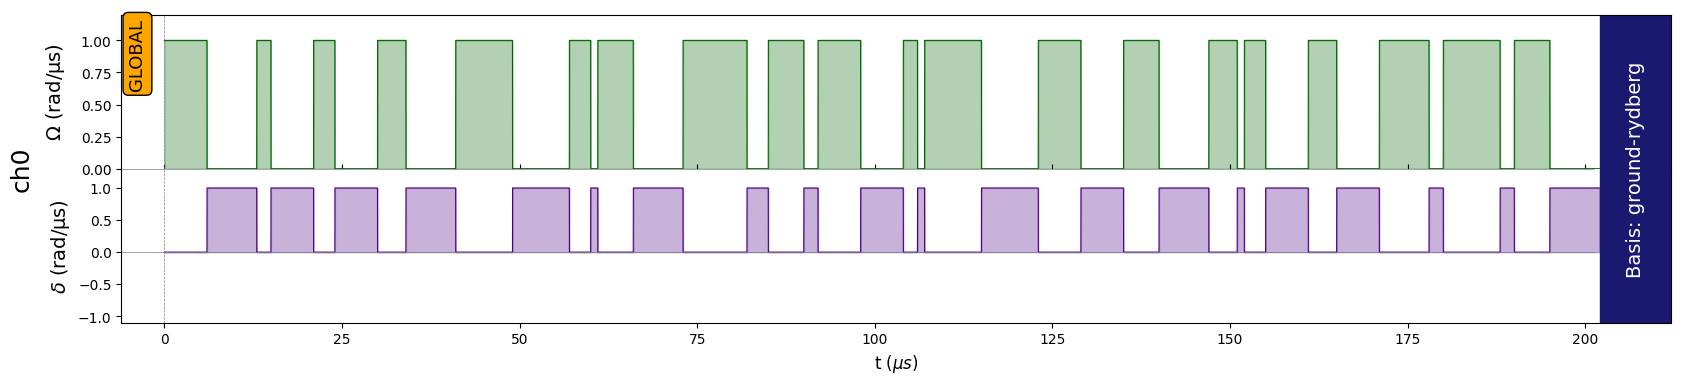

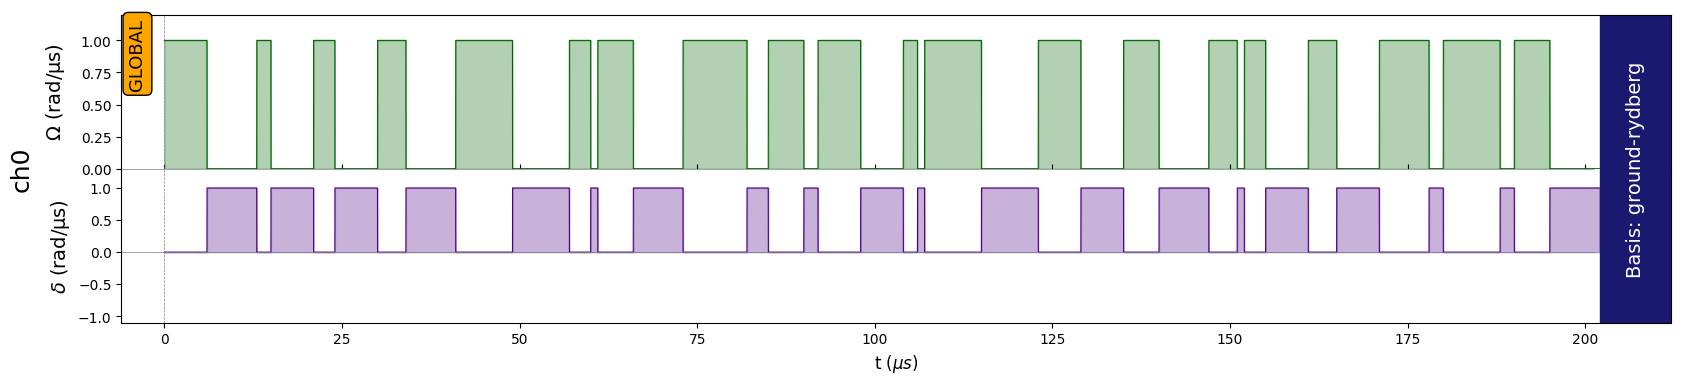

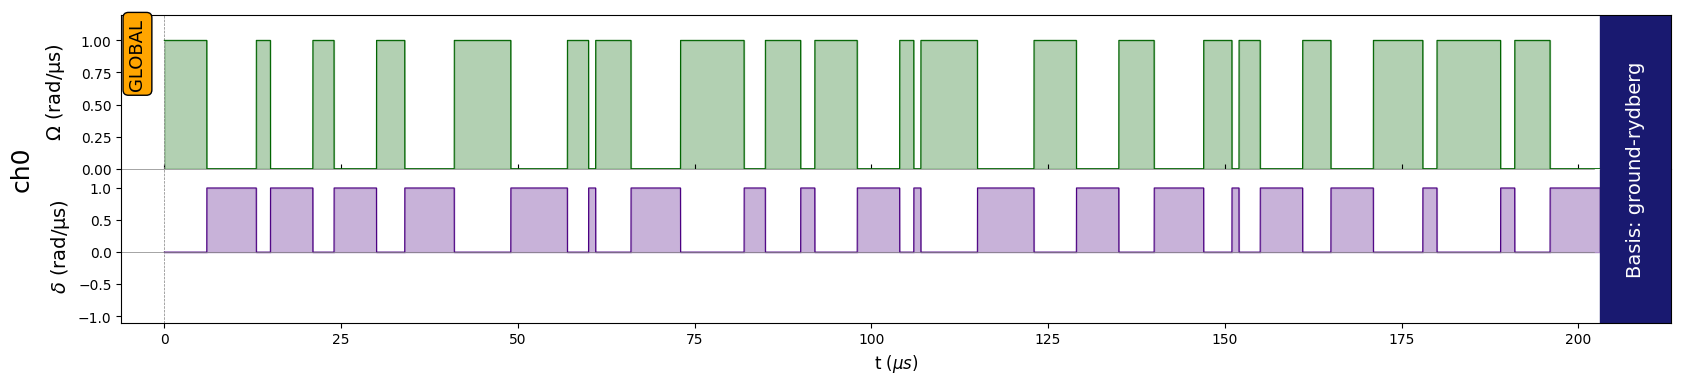

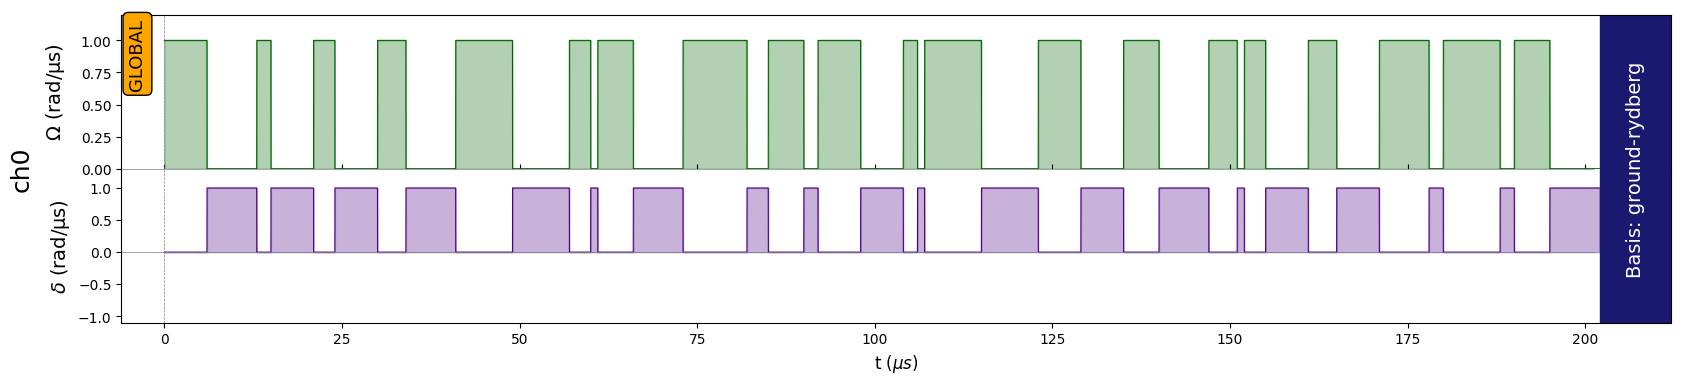

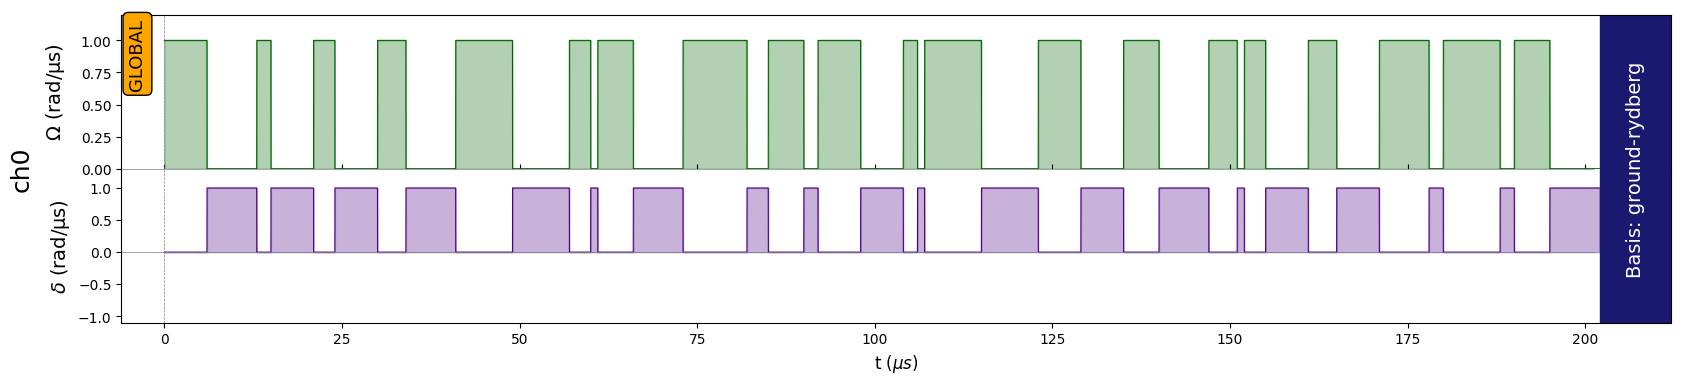

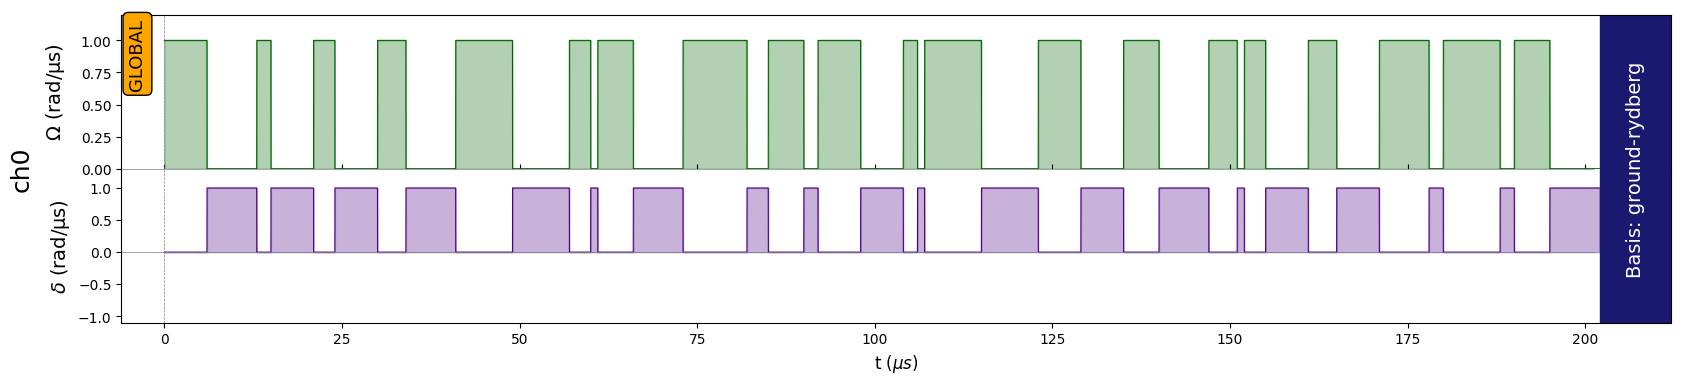

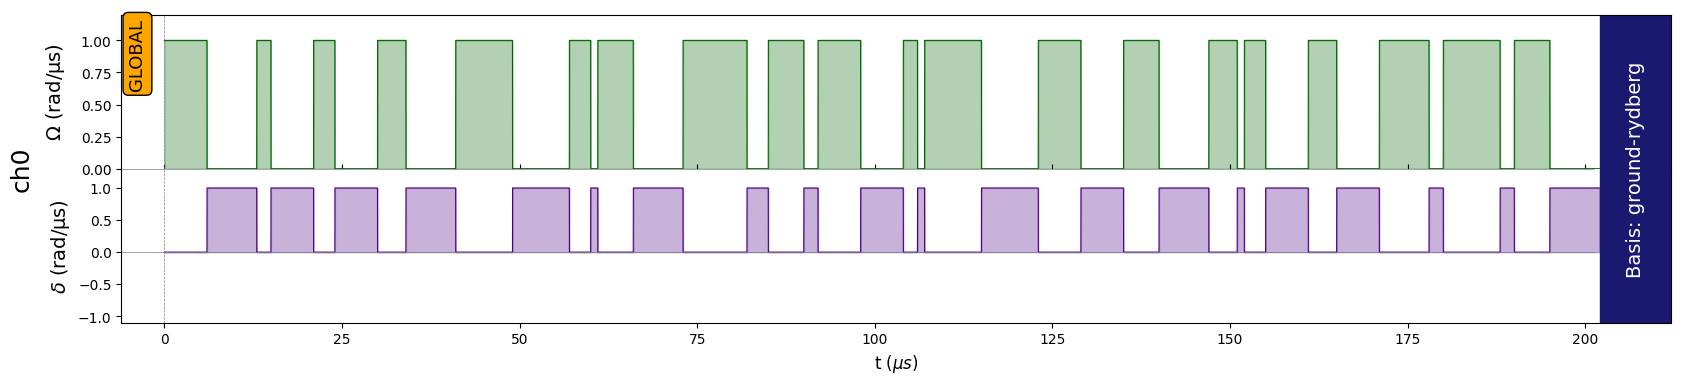

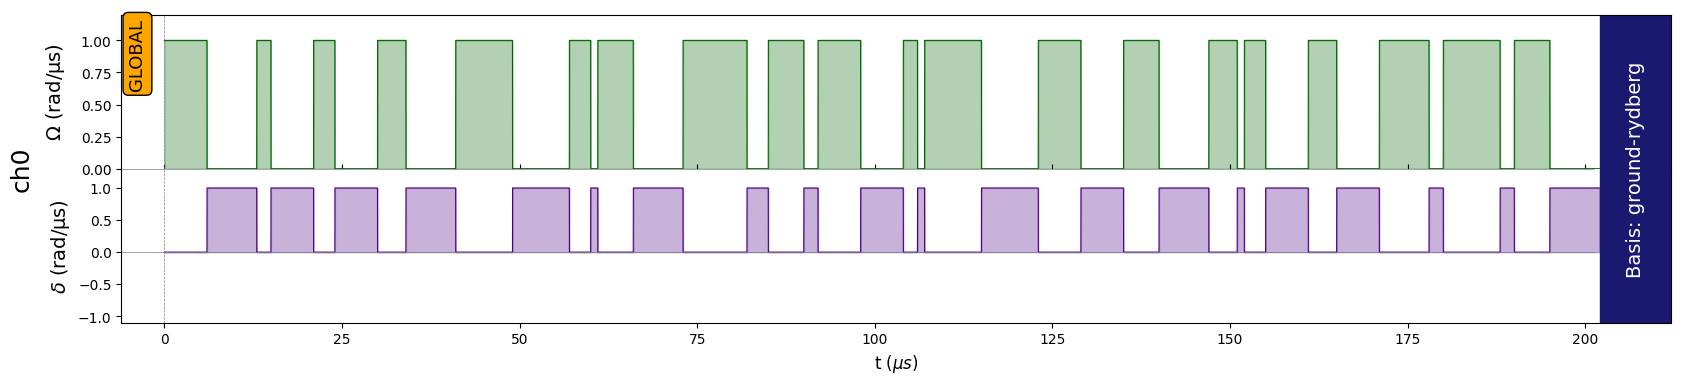

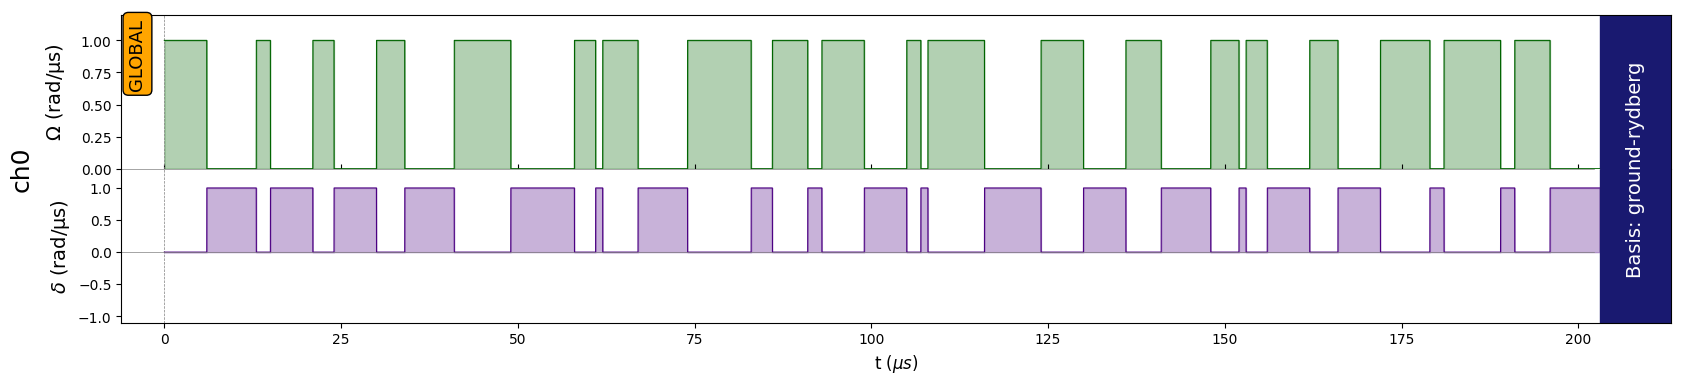

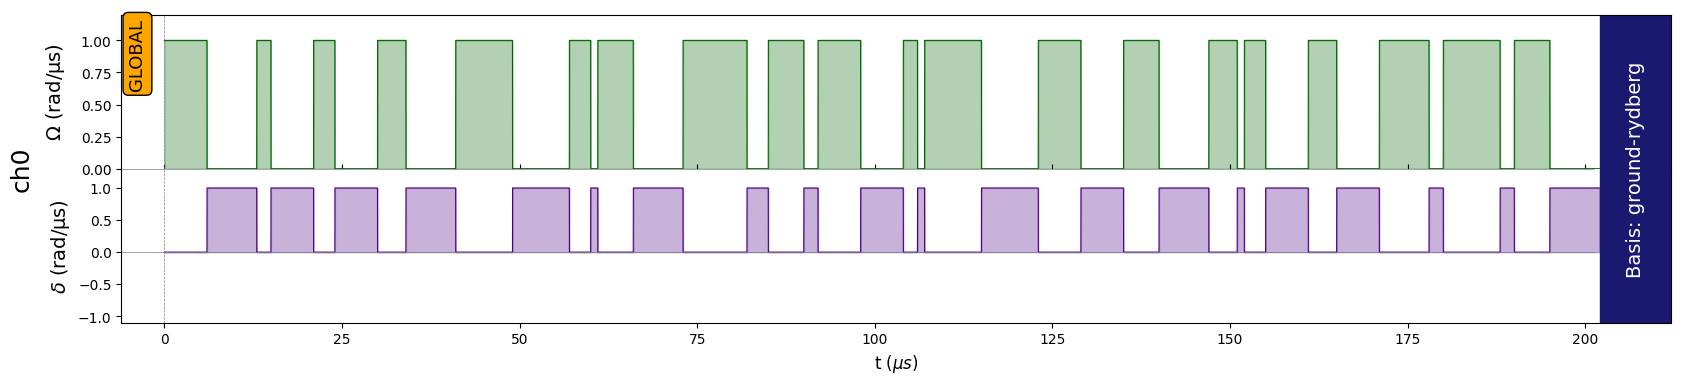

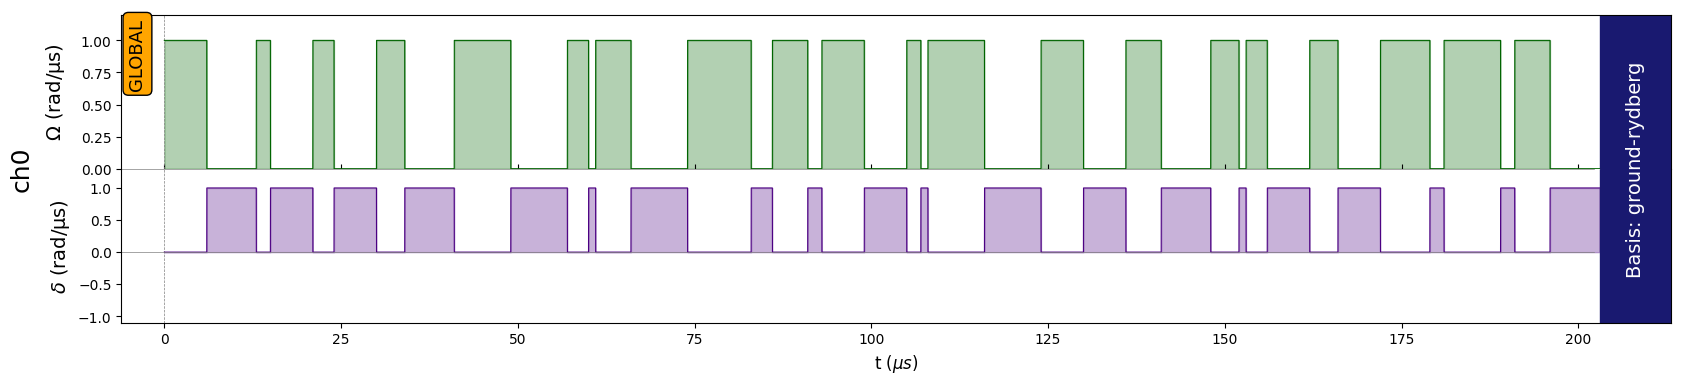

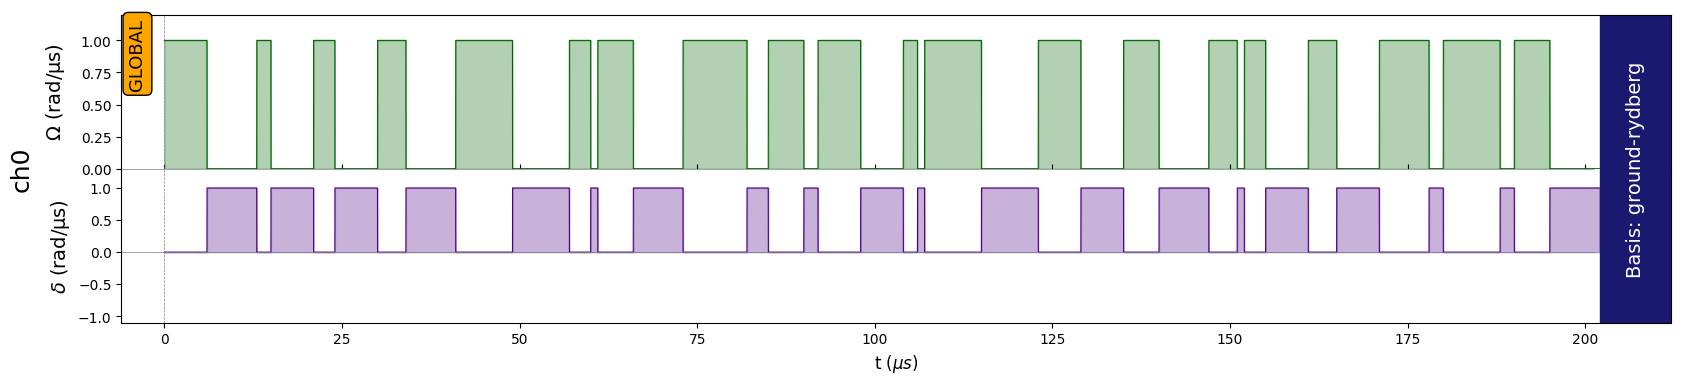

KeyboardInterrupt: 

In [108]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

In [ ]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)